Comparing ML algorithms on classification problem for 16 model in PyCarat.

https://www.kaggle.com/code/frtgnn/pycaret-introduction-classification-regression

In [ ]:
!pip install -qqq --ignore-installed pycaret

In [2]:
import numpy as np
import pandas as pd
#pd.set_option("future.no_silent_downcasting", True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna
import matplotlib.pyplot as plt
from IPython.display import display
from pycaret.classification import *

In [5]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv',index_col='PassengerId')
test_data = pd.read_csv("/kaggle/input/titanic/test.csv", index_col='PassengerId')
train_data.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


### Preprocess Data

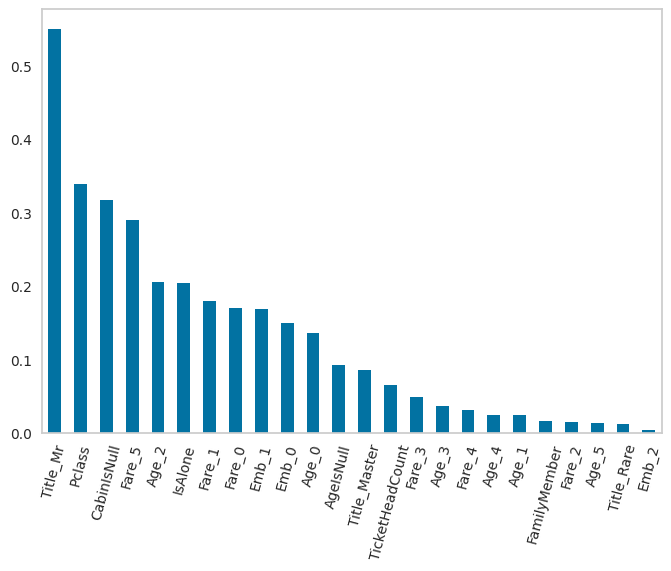

In [6]:
def preprocess_data(combined_data):
    social_status_mapping = {'Capt': 'Rare', 'Col': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Dr': 'Rare', 'Jonkheer': 'Rare', 'Lady': 'Rare', 'Major': 'Rare', 'Mlle': 'Miss', 'Mme': 'Miss', 'Mrs':'Miss', 'Ms': 'Miss', 'Rev': 'Rare', 'Sir': 'Rare', 'the Countess': 'Rare'}
    
    # full data
    total_data = pd.concat(combined_data)
    head_count = pd.Series(total_data.groupby(['Ticket'])['Name'].count()).to_dict()

    total_data['Title'] = total_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    age = total_data.groupby(['Title', 'Pclass'])['Age'].transform('median').fillna(total_data['Age'].median())
    combined_age = [age.iloc[:len(combined_data[0])], age.iloc[len(combined_data[0]):]]

    for data, age in zip(combined_data, combined_age):
        # imputing missing values
        data['Title'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
        data['AgeIsNull'] = np.where(data['Age'].isnull(), 1, 0)
        data['Age'] = np.where(data.Age.isnull(), age, data.Age)
        data['Fare'] = data['Fare'].fillna(data.Fare.median())
        data['CabinIsNull'] = np.where(data['Cabin'].isnull(), 1, 0)
        data['Cabin'] = data['Cabin'].fillna('NA')
        data['Embarked'] = data['Embarked'].fillna('S')
        data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

        # formating categorical features
        data['Title'] = data['Title'].replace(social_status_mapping)
        data['Sex'] = data['Sex'].replace({'female':0, 'male':1})
        data['TicketHeadCount'] = data['Ticket'].replace(head_count)

        # formating Numerical features
        data['AgeBin'] = pd.qcut(data['Age'], q=6, duplicates='drop', labels=False)
        data['FareBin'] = pd.qcut(data['Fare'], q=6, duplicates='drop', labels=False)
        data['IsAlone'] = np.where((data.Parch==0) & (data.SibSp==0), 1, 0)
        data['FamilyMember'] = data['SibSp'] + data['Parch'] + 1

def show_corr_plot(data, drop_features=[]):
    survived = data.Survived
    corr = data.drop(['Survived'] + drop_features, axis=1).corrwith(survived)
    corr = abs(corr)
    corr.sort_values(ascending=False,inplace=True)
    ax = corr.plot.bar(rot = 75)
    ax.grid(False)
    plt.show()

combined_data = [train_data, test_data]
preprocess_data(combined_data)

# performing one hot encoding
train_data = pd.get_dummies(train_data,columns=["Title","Embarked",'AgeBin','FareBin'], prefix=["Title","Emb",'Age','Fare'])
test_data = pd.get_dummies(test_data,columns=["Title","Embarked",'AgeBin','FareBin'], prefix=["Title","Emb",'Age','Fare'])

# dropping unnecessary features
drop = ['Name', 'Age', 'Ticket', 'Fare', 'Cabin', 'Title_Miss', 'Sex', 'Parch', 'SibSp']
train_data = train_data.drop(drop, axis=1)
test_data = test_data.drop(drop, axis=1)

# show corr plot
show_corr_plot(train_data)

In [43]:
x_train = train_data # train_data.drop('Survived', axis=1)
y_train = train_data['Survived']
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.17, random_state = 42)

clf1 = setup(data=x_train,
             target = 'Survived',
             categorical_features=['Title_Mr', 'Pclass', 'CabinIsNull', 'Fare_5', 'Age_2', 'IsAlone'])

,Description,Value
0,Session id,1485
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(739, 25)"
4,Transformed data shape,"(739, 27)"
5,Transformed train set shape,"(517, 27)"
6,Transformed test set shape,"(222, 27)"
7,Numeric features,3
8,Categorical features,6
9,Preprocess,True


### Comparing
`compare_models` for algorithms list in comapring for model pick in next step.

In [45]:
top = compare_models(fold=5, n_select=16)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8220,0.8462,0.7459,0.7790,0.7617,0.6197,0.6205,0.2820
lda,Linear Discriminant Analysis,0.8219,0.8338,0.7151,0.8002,0.7544,0.6153,0.6186,0.2320
ridge,Ridge Classifier,0.8199,0.8353,0.7151,0.7948,0.7522,0.6114,0.6141,0.2220
lightgbm,Light Gradient Boosting Machine,0.8142,0.8484,0.7151,0.7822,0.7456,0.5998,0.6028,0.1920
lr,Logistic Regression,0.8141,0.8330,0.7151,0.7855,0.7473,0.6007,0.6038,0.2340
catboost,CatBoost Classifier,0.8123,0.8541,0.6899,0.7909,0.7367,0.5919,0.5954,1.7900
gbc,Gradient Boosting Classifier,0.8122,0.8534,0.6996,0.7856,0.7387,0.5930,0.5966,0.3160
rf,Random Forest Classifier,0.8065,0.8392,0.6899,0.7775,0.7306,0.5805,0.5834,0.3520
xgboost,Extreme Gradient Boosting,0.8065,0.8408,0.6846,0.7813,0.7290,0.5795,0.5832,0.2180
et,Extra Trees Classifier,0.7968,0.8227,0.6695,0.7680,0.7146,0.5581,0.5619,0.3060


Model optimize in PyCaret.

### Models Selection and Ensemble
1. To pick up top 3 in models for ensemble.
2. `tune_model` for the hyperparameters of a given estimator.
3. `stack_models` and `blend_models` for ensemble after models selection.  

https://pycaret.readthedocs.io/en/stable/api/classification.html#pycaret.classification.tune_model
https://stackoverflow.com/questions/74616385/pycaret-blend-stack-tuned-models

In [222]:
best = top[:3]
display(pd.DataFrame([type(i).__name__ for i in top[:3]], columns=['Model']))
tuned_best = [tune_model(i, verbose=False, tuner_verbose=False) for i in best]
stacker = stack_models(estimator_list = tuned_best, meta_model = best[0], verbose=False)
blender = blend_models(tuned_best, verbose=False)

,Model
0,AdaBoostClassifier
1,LinearDiscriminantAnalysis
2,RidgeClassifier


### Ensemble Selection and Prediction
1. To pick ensemble by accuracy and figures.
2. Exporting predication data.

In [230]:
def to_pred_series(val_pred):
    return pd.Series(val_pred['prediction_label'], index=val_pred.index).values

def get_best_ensemble():
    y_val_stacker_pred = to_pred_series(predict_model(stacker, data=x_val))
    y_val_blender_pred = to_pred_series(predict_model(blender, data=x_val))
    ac1 = accuracy_score(y_val, y_val_stacker_pred)
    ac2 = accuracy_score(y_val, y_val_blender_pred)
    best, y_val_pred, ac = (stacker, y_val_stacker_pred, ac1) if ac1>ac2 else (blender, y_val_blender_pred, ac2)
    print("%s Accuracy: %s" % (type(best).__name__, round(ac,2)))
    print("Classification Report:\n", classification_report(y_val, y_val_pred))
    print("Confusion Matrix:\n",confusion_matrix(y_val, y_val_pred))
    return best
    
best_ensemble = get_best_ensemble()

# if needed, save predictions to a CSV file
y_test_pred = to_pred_series(predict_model(best_ensemble, data=test_data))
output = pd.DataFrame({'PassengerId': pd.read_csv("/kaggle/input/titanic/test.csv")["PassengerId"], 'Survived': y_test_pred})
output.to_csv("/kaggle/working/submission.csv", index=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8158,0.8589,0.8033,0.7538,0.7778,0.6207,0.6217


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8421,0.8357,0.8033,0.8033,0.8033,0.6714,0.6714


VotingClassifier Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        91
           1       0.80      0.80      0.80        61

    accuracy                           0.84       152
   macro avg       0.84      0.84      0.84       152
weighted avg       0.84      0.84      0.84       152

Confusion Matrix:
 [[79 12]
 [12 49]]


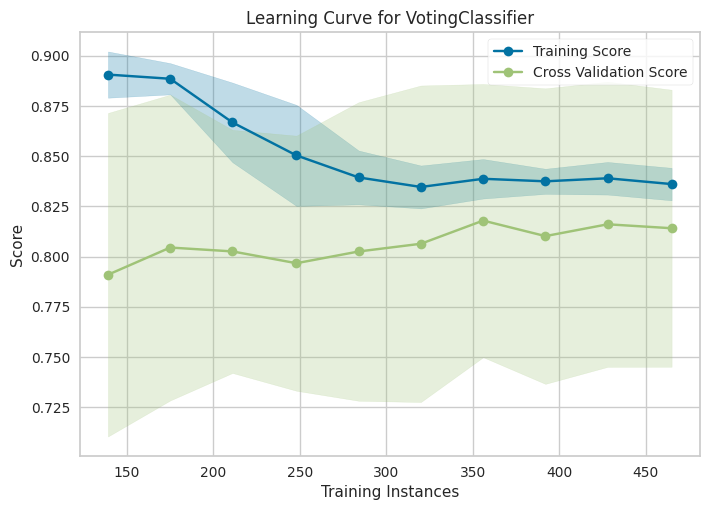

In [223]:
plot_model(estimator = best_ensemble, plot = 'learning')